## Movie Recommendation with Content-Based and Collaborative Filtering
<p>“What movie should I watch this evening?” </p>

<p>Have you ever had to answer this question at least once when you came home from work? As for me — yes, and more than once. From Netflix to Hulu, the need to build robust movie recommendation systems is extremely important given the huge demand for personalized content of modern consumers.</p>

<p>An example of recommendation system is such as this:</p>

- User A watches Game of Thrones and Breaking Bad.
- User B does search on Game of Thrones, then the system suggests Breaking Bad from data collected about user A.
<p>
Recommendation systems are used not only for movies, but on multiple other products and services like Amazon (Books, Items), Pandora/Spotify (Music), Google (News, Search), YouTube (Videos) etc.
</p>

<p>
Two most ubiquitous types of personalized recommendation systems are Content-Based and Collaborative Filtering. Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the “wisdom of the crowd” to recommend items. In contrast, content-based recommendation systems focus on the attributes of the items and give you recommendations based on the similarity between them.

In this notebook, I will attempt at implementing these two systems to recommend movies and evaluate them to see which one performs better.

After reading this post you will know:
</p>

- About the MovieLens dataset problem for recommender system.
- How to load and process the data.
- How to do exploratory data analysis.
- The 2 different types of recommendation engines.
- How to develop a content-based recommendation model based on movie genres.
- How to develop a collaborative filtering model based on user ratings.
- Alternative approach to improve existing models.

### The MovieLens Dataset

One of the most common datasets that is available on the internet for building a Recommender System is the [MovieLens DataSet](https://grouplens.org/datasets/movielens/) . This version of the dataset that I'm working with [1M](https://grouplens.org/datasets/movielens/1m/) contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

The data was collected by GroupLens researchers over various periods of time, depending on the size of the set. This 1M version was released on February 2003. Users were selected at random for inclusion. All users selected had rated at least 20 movies. Each user is represented by an id, and no other information is provided.


The original data are contained in three files, movies.dat, ratings.dat and users.dat. To make it easier to work with the data, I converted them into csv files. The process can be viewed in my Data Processing Notebook.

### Data Preparation

Let's load this data into Python. I will load the dataset with Pandas onto Dataframes ratings, users, and movies.

# <center><i><b> Import Libraries

In [71]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
# from surprise import Reader, Dataset, SVD
# from surprise.model_selection import cross_validate
import numpy as np
# from surprise.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')
sb.set_style("dark")

# <center><i><b> Loading Datasets

In [72]:
# ../../Data/ml-1m/
ratings = pd.read_csv('../../Data/ml-1m/ratings.csv', sep='\t', encoding='latin-1', usecols=['UserID', 'MovieID', 'Ratings', 'Timestamp'])

users = pd.read_csv('../../Data/ml-1m/users.csv', sep='\t', encoding='latin-1', usecols=['UserID', 'Gender', 'Age', 'Occupation', 'Zip Code', 'age_desc', 'occ_desc'])

movies = pd.read_csv('../../Data/ml-1m/movies.csv', sep='\t', encoding='latin-1', usecols=['MovieID', 'Title', 'Genres'])

### **Ratings Dataset**

In [73]:
ratings.head()

,UserID,MovieID,Ratings,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [74]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [75]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Ratings    1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [76]:
ratings.shape

(1000209, 4)

### **User Dataset**

In [77]:
users.head()

,UserID,Gender,Age,Occupation,Zip Code,age_desc,occ_desc
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


In [78]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip Code    6040 non-null   object
 5   age_desc    6040 non-null   object
 6   occ_desc    6040 non-null   object
dtypes: int64(3), object(4)
memory usage: 330.4+ KB


In [79]:
users.shape

(6040, 7)

### **Movies Dataset**

In [80]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [81]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Title    3883 non-null   object
 2   Genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [82]:
movies.shape

(3883, 3)

### **Data Exploration**
**Titles**
- Are there certain words that feature more often in Movie Titles? I'll attempt to figure this out using a word-cloud visualization

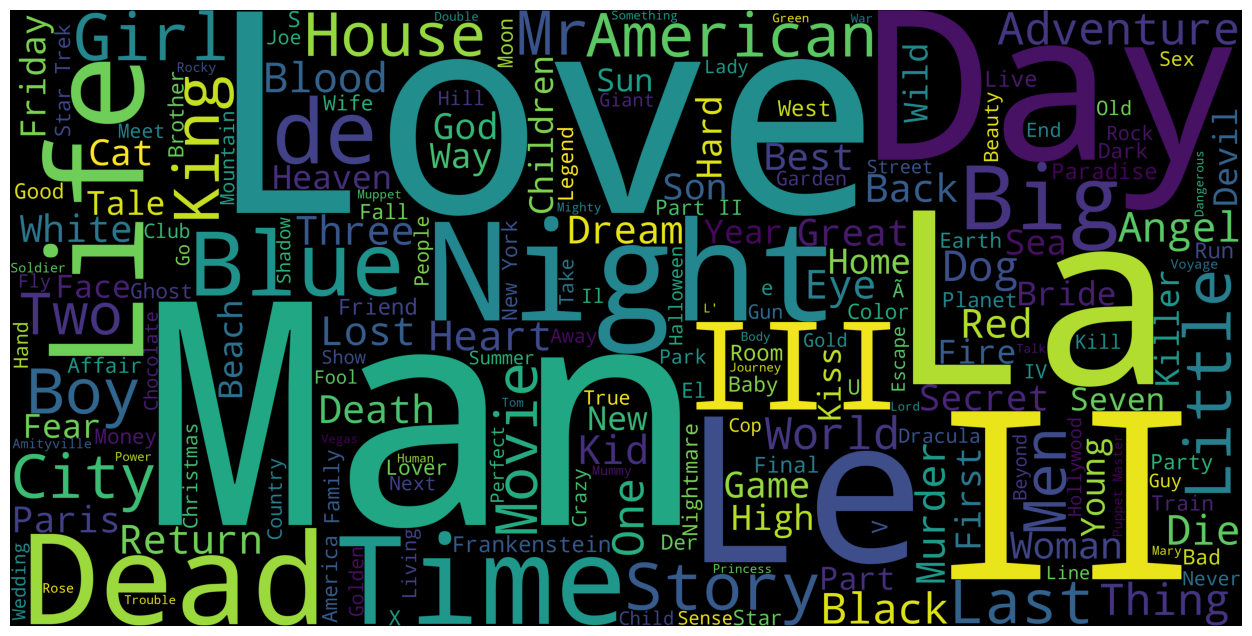

In [83]:
title_corpus = " ".join(movies['Title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

plt.figure(figsize=(16, 8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

### **Genres**

- The genres variable will surely be important while building the recommendation engines since it describes the content of the film (i.e. Animation, Horror, Sci-Fi). A basic assumption is that films in the same genre should have similar contents. I'll attempt to see exactly which genres are the most popular.

In [84]:
full_Df = pd.merge((pd.merge(movies, ratings)), users)

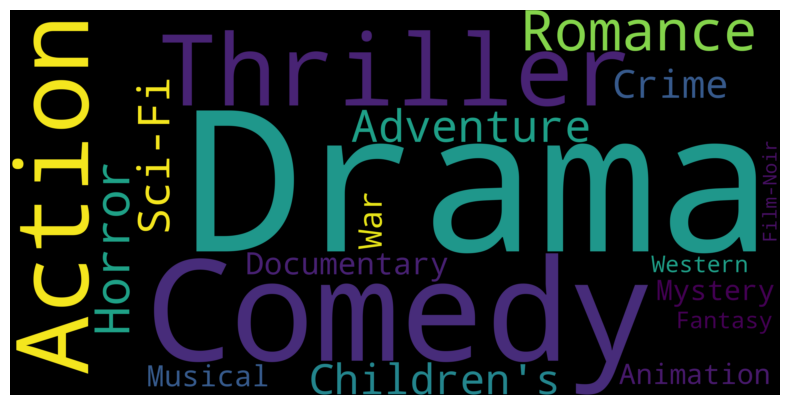

In [85]:
all_genres = movies['Genres'].str.split('|').explode()
genres_word_count = all_genres.value_counts()


genres_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate_from_frequencies(genres_word_count)

plt.figure(figsize=(10, 5))
plt.imshow(genres_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Types of Recommendation Engines

1. **Content-Based**

The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it's easy to determine the context/properties of each item.

    - A content based recommender works with data that the user provides, either explicitly movie ratings for the MovieLens dataset. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

2. **Collaborative Filtering**

The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that.


    - For instance, if user A likes movies 1, 2, 3 and user B likes movies 2,3,4, then they have similar interests and A should like movie 4 and B should like movie 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.


In general, collaborative filtering is the workhorse of recommender engines. The algorithm has a very interesting property of being able to do feature learning on its own, which means that it can start to learn for itself what features to use. It can be divided into Memory-Based Collaborative Filtering and Model-Based Collaborative filtering. In this post, I'll only focus on the Memory-Based Collaborative Filtering technique.



![image.png](https://raw.githubusercontent.com/khanhnamle1994/movielens/cb1fe40c99cdd61c3c714e501e11f699c87b0eed/images/rec-systems.png)


## <center> Content-Based Recommendation Model </center>

**Theory**

The concepts of <b> Term Frequency (TF) and Inverse Document Frequency (IDF) </b> are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for <b> “the results of latest European Socccer games” </b> on Google. It is certain that “the” will occur more frequently than “soccer games” but the relative importance of soccer games is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).



Below is the equation to calculate the TF-IDF score: tfidf

![image.png](https://raw.githubusercontent.com/khanhnamle1994/movielens/cb1fe40c99cdd61c3c714e501e11f699c87b0eed/images/tfidf.jpg)

After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile? This is accomplished using the Vector Space Model which computes the proximity based on the angle between the vectors. In this model, each item is stored as a vector of its attributes (which are also vectors) in an n-dimensional space and the angles between the vectors are calculated to determine the similarity between the vectors. Next, the user profile vectors are also created based on his actions on previous attributes of items and the similarity between an item and a user is also determined in a similar way.

![image.png](https://raw.githubusercontent.com/khanhnamle1994/movielens/cb1fe40c99cdd61c3c714e501e11f699c87b0eed/images/vector_space.png)

Sentence 2 is more likely to be using Term 2 than using Term 1. Vice-versa for Sentence 1. The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. The ultimate reason behind using cosine is that the value of cosine will increase with decreasing value of the angle between which signifies more similarity. The vectors are length normalized after which they become vectors of length 1 and then the cosine calculation is simply the sum-product of vectors.

## Implementation

- With all that theory in mind, I am going to build a Content-Based Recommendation Engine that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre. To do so, I will make use of the file movies.csv

**Clean the Genres Column**

In [86]:
movies['Genres'] = movies['Genres'].fillna('')

**Preprocess the Genres Column**

In [87]:
movies['Genres'] = movies['Genres'].apply(lambda x:x.split("|"))

**Transform Genres into a Machine-Readable Format**

In [90]:
movies['Genres_str'] = movies['Genres'].apply(lambda x: " ".join(x))

In [93]:
movies['Genres'] = movies['Genres'].apply(lambda x: ", ".join(x))

**Use a text vectorization technique, such as TF-IDF or Count Vectorizer, to represent Genres numerically.**

- Using TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tfidf.fit_transform(movies['Genres_str'])

In [25]:
tfidf_matrix.shape

(3883, 20)

### **Compute Similarity**
- I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Since we have used the TF-IDF Vectorizer,<br> calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [26]:
cosine_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [27]:
indicies = pd.Series(movies.index, index=movies['Title']).drop_duplicates()

**Build the Recommendation Function**

In [28]:
def recommend(title, cosine_sim=cosine_matrix):
    idx = indicies[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]

    movie_indices = [i[0] for i in sim_scores]
    return movies['Title'].iloc[movie_indices]

**Evaluate and Test**

In [29]:
pd.DataFrame(recommend("Toy Story (1995)")).reset_index().drop(columns = 'index')

,Title
0,Aladdin and the King of Thieves (1996)
1,"American Tail, An (1986)"
2,"American Tail: Fievel Goes West, An (1991)"
3,"Rugrats Movie, The (1998)"
4,"Bug's Life, A (1998)"
5,Toy Story 2 (1999)
6,Saludos Amigos (1943)
7,Chicken Run (2000)
8,"Adventures of Rocky and Bullwinkle, The (2000)"
9,Balto (1995)


<b>As you can see, I have quite a decent list of recommendation for Good Will Hunting (Drama), Toy Story (Animation, Children's, Comedy)</b>

**Overall, here are the pros of using content-based recommendation:**

- No need for data on other users, thus no cold-start or sparsity problems.
- Can recommend to users with unique tastes.
- Can recommend new & unpopular items.
- Can provide explanations for recommended items by listing content-features that caused an item to be recommended (in this case, movie genres)

<b>
However, there are some cons of using this approach:
</b>

- Finding the appropriate features is hard.
- Does not recommend items outside a user's content profile.
- Unable to exploit quality judgments of other users.

## <center> Collaborative Filtering Recommendation Model</center>

The content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, I will use Memory-Based Collaborative Filtering to make recommendations to movie users. The technique is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

### **Theory**

There are 2 main types of memory-based collaborative filtering algorithms:

1. **User-User Collaborative Filtering**: Here we find look alike users based on similarity and recommend movies which first user’s look-alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.

2. **Item-Item Collaborative Filtering**: It is quite similar to previous algorithm, but instead of finding user's look-alike, we try finding movie's look-alike. Once we have movie's look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of movies, movie-movie look alike matrix is fixed over time.

![image.png](https://raw.githubusercontent.com/khanhnamle1994/movielens/cb1fe40c99cdd61c3c714e501e11f699c87b0eed/images/dimensionality-reduction.jpg)

In either scenario, we builds a similarity matrix. For user-user collaborative filtering, the user-similarity matrix will consist of some distance metrics that measure the similarity between any two pairs of users. Likewise, the item-similarity matrix will measure the similarity between any two pairs of items.

There are 3 distance similarity metrics that are usually used in collaborative filtering:

1.**Jaccard Similarity:**

 - Similarity is based on the number of users which have rated item A and B divided by the number of users who have rated either A or B
 - It is typically used where we don’t have a numeric rating but just a boolean value like a product being bought or an add being clicked

2. **Cosine Similarity: (as in the Content-Based system):**

 - Similarity is the cosine of the angle between the 2 vectors of the item vectors of A and B
 - Closer the vectors, smaller will be the angle and larger the cosine

3. **Pearson Similarity:**

 - Similarity is the pearson coefficient between the two vectors.
 - For the purpose of diversity, I will use Pearson Similarity in this implementation.

### Implementation (Build the Collaborative Recommendation System)

I will use the file ratings.csv first as it contains User ID, Movie IDs and Ratings. These three elements are all I need for determining the similarity of the users based on their ratings for a particular movie.

- First I do some quick data processing:

In [30]:
ratings.isna().sum()

UserID       0
MovieID      0
Ratings      0
Timestamp    0
dtype: int64

In [31]:
n_users = ratings['UserID'].unique().shape[0]
n_movies = ratings['MovieID'].unique().shape[0]
n_users, n_movies

(6040, 3706)

**Prepare the Utility Matrix (Done)**

In [32]:
Ratings = ratings.pivot(index = 'UserID', columns ='MovieID', values = 'Ratings').fillna(0)

**Normalize the Data**

- Collaborative filtering often benefits from normalizing the data. For SVD, subtract each user's mean rating to center their preferences:

In [33]:
Ratings.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Last but not least, I need to de-normalize the data (normalize by each users mean) and convert it from a dataframe to a numpy array.


In [34]:
R = np.matrix(Ratings)

In [35]:
user_means = np.mean(R, axis=1)
normalized_ratings = R - user_means.reshape(-1, 1)

 - let's check the sparsity of the ratings dataset:

In [36]:
print(f"The sparsity level of dataset is {round(1.0 - len(ratings) / float(n_users * n_movies), 3)*100}%")

The sparsity level of dataset is 95.5%


## Support Vector Decomposition (SVD)
- A well-known matrix factorization method is Singular value decomposition (SVD). At a high level, SVD is an algorithm that decomposes a matrix
 into the best lower rank (i.e. smaller/simpler) approximation of the original matrix
. Mathematically, it decomposes A into a two unitary matrices and a diagonal matrix:

![image.png](https://raw.githubusercontent.com/khanhnamle1994/movielens/cb1fe40c99cdd61c3c714e501e11f699c87b0eed/images/svd.png)

**Setting Up SVD**

In [117]:
U, sigma, Vt = svds(normalized_ratings, k=50)

- As I'm going to leverage matrix multiplication to get predictions, I'll convert the
 sigma(now are values) to the diagonal matrix form.

In [118]:
sigma = np.diag(sigma)

In [119]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_means.reshape(-1, 1)

- Making Predictions from the Decomposed Matrices

- With the predictions matrix for every user, I can build a function to recommend movies for any user. I return the list of movies the user has already rated, for the sake of comparison.

In [120]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,...,0.027807,0.001640,0.026395,-0.022024,-0.085415,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,...,-0.056502,-0.013733,-0.010580,0.062576,-0.016248,0.155790,-0.418737,-0.101102,-0.054098,-0.140188
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,...,0.040481,-0.005301,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,-0.109956
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,...,0.008571,-0.005425,-0.008500,-0.003417,-0.083982,0.094512,0.057557,-0.026050,0.014841,-0.034224
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,...,0.110151,0.046010,0.006934,-0.015940,-0.050080,-0.052539,0.507189,0.033830,0.125706,0.199244


**Now I write a function to return the movies with the highest predicted rating that the specified user hasn't already rated. Though I didn't use any explicit movie content features (such as genre or title), I'll merge in that information to get a more complete picture of the recommendations.**

In [121]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations=10):
    """
    Recommend movies to a user based on predicted ratings.

    Parameters:
    - predictions (DataFrame): DataFrame of predicted ratings for all users and movies.
    - userID (int): The user ID for whom recommendations are to be made.
    - movies (DataFrame): DataFrame containing movie metadata (e.g., IDs, titles).
    - original_ratings (DataFrame): DataFrame containing the original user-movie ratings.
    - num_recommendations (int): Number of movie recommendations to return (default: 10).

    Returns:
    - user_full (DataFrame): Movies already rated by the user with their ratings.
    - recommendations (DataFrame): Top N recommended movies the user hasn't rated.
    """
    # Get the user's row index in the predictions DataFrame
    user_row_number = userID - 1  # Adjust for 0-based indexing

    # Sort predictions for the user in descending order of rating
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False)

    # Retrieve movies already rated by the user
    user_data = original_ratings[original_ratings["UserID"] == userID]
    user_full = (
        user_data.merge(movies, how="left", on="MovieID")
        .sort_values(["Ratings"], ascending=False)
    )

    # Log information about the user's rated movies
    print(f"User {userID} has already rated {user_full.shape[0]} movies.")
    print(f"Recommending top {num_recommendations} movies with highest predicted ratings not already rated.")

    # Identify movies not yet rated by the user and merge with predictions
    recommendations = (
        movies[~movies["MovieID"].isin(user_full["MovieID"])]
        .merge(
            pd.DataFrame(sorted_user_predictions).reset_index(),
            how="left",
            on="MovieID"
        )
        .rename(columns={user_row_number: "Predictions"})
        .sort_values("Predictions", ascending=False)
        .iloc[:num_recommendations, :]  # Select top N recommendations
    )

    return user_full, recommendations


- Let's try to recommend 20 movies for user with ID 222.

In [122]:
already_rated, predictions = recommend_movies(preds, 1310, movies, ratings, 10)

User 1310 has already rated 24 movies.
Recommending top 10 movies with highest predicted ratings not already rated.


In [123]:
already_rated.head(10)

,UserID,MovieID,Ratings,Timestamp,Title,Genres,Genres_str
5,1310,2248,5,974781573,Say Anything... (1989),"[Comedy, Drama, Romance]",Comedy Drama Romance
6,1310,2620,5,974781573,This Is My Father (1998),"[Drama, Romance]",Drama Romance
7,1310,3683,5,974781935,Blood Simple (1984),"[Drama, Film-Noir]",Drama Film-Noir
15,1310,1704,5,974781573,Good Will Hunting (1997),[Drama],Drama
1,1310,1293,5,974781839,Gandhi (1982),[Drama],Drama
12,1310,3101,4,974781573,Fatal Attraction (1987),[Thriller],Thriller
11,1310,1343,4,974781534,Cape Fear (1991),[Thriller],Thriller
20,1310,2000,4,974781892,Lethal Weapon (1987),"[Action, Comedy, Crime, Drama]",Action Comedy Crime Drama
18,1310,3526,4,974781892,Parenthood (1989),"[Comedy, Drama]",Comedy Drama
17,1310,3360,4,974781935,Hoosiers (1986),[Drama],Drama


# Model Evaluation

Can't forget to evaluate our model, can we?

Instead of doing manually like the last time, I will use the Surprise library that provided various ready-to-use powerful prediction algorithms including (SVD) to evaluate its RMSE (Root Mean Squared Error) on the MovieLens dataset. It is a Python scikit building and analyzing recommender systems.

In [124]:
# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Ratings']], reader)

- Split the dataset for train, test

In [125]:
trainset, testset = train_test_split(data, test_size=.2)

- Use the SVD algorithm.
- Compute the RMSE of the SVD algorithm.

In [126]:
model = SVD()

result = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=False)

- Evaluating RMSE of algorithm SVD.

In [127]:
pd.DataFrame(result)

,test_rmse,fit_time,test_time
0,0.874225,17.266903,2.533842
1,0.872412,17.507204,2.979546
2,0.873400,18.779943,2.488152
3,0.873798,17.753987,3.626131
4,0.876515,17.833706,2.488123


- The test_rmse values you received represent the Root Mean Squared Error (RMSE) for each fold during cross-validation. Lower RMSE values indicate better predictions, as they show less deviation between predicted and actual ratings

In [128]:
print("Average RMSE:", result['test_rmse'].mean())

Average RMSE: 0.8740700070555171


- Fit model on train data

In [129]:
model.fit(trainset)

- I'll pick again user with ID 222 and check the ratings he has given.

In [130]:
ratings[ratings['UserID'] == 222]

,UserID,MovieID,Ratings,Timestamp
32704,222,2987,2,976834933
32705,222,1250,5,976835036
32706,222,3793,3,976834541
32707,222,2054,3,976834859
32708,222,1259,4,976834933
...,...,...,...,...
32779,222,1233,4,976834289
32780,222,1097,4,976834803
32781,222,1240,4,976834492
32782,222,3785,3,976834014


- Now let's use SVD to predict the rating that User with ID 222 will give to a random movie (let's say with Movie ID 2987).

In [131]:
model.predict(222, 2987)

Prediction(uid=222, iid=2987, r_ui=None, est=3.9088677911519882, details={'was_impossible': False})

For movie with ID 2987, I get an estimated prediction of 4.1065 The recommender system works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## Conclusion

In this notebook, I attempted to build a model-based Collaborative Filtering movie recommendation sytem based on latent features from a low rank matrix factorization method called SVD. As it captures the underlying features driving the raw data, it can scale significantly better to massive datasets as well as make better recommendations based on user's tastes.

However, we still likely lose some meaningful signals by using a low-rank approximation. Specifically, there's an interpretability problem as a singular vector specifies a linear combination of all input columns or rows. There's also a lack of sparsity when the singular vectors are quite dense. Thus, SVD approach is limited to linear projections.

# <center> **Hybrid recommendation system**</center>
- A hybrid recommendation system is a framework that combines multiple recommendation systems to generate personalized recommendations for users. Hybrid systems can use a variety of data sources, including user preferences, item content, and reviews, to improve the accuracy and diversity of recommendations. <br>
- The most common combination of recommendation systems in a hybrid system is content-based filtering and collaborative filtering. However, it's also possible to combine different techniques of the same type. For example, one hybrid system combines collaborative filtering with deep learning to improve recommendation performance.
<br>
- Hybrid recommendation systems are often used in recommendation engines for e-commerce websites, music streaming services, and movie recommendation services.

![image.png](https://www.researchgate.net/profile/Gabriele-Sottocornola/publication/319045879/figure/fig1/AS:530613683273728@1503519568040/Hybrid-recommendation-model.png)

### **Hybrid Recommendation System**

To integrate content-based and collaborative filtering:

Combining Predictions
We already have:

  1. Content-based predictions (cosine_matrix): Gives similarity scores for movies based on metadata (e.g., genres).
  2. Collaborative filtering predictions (preds): Estimates how much a user will like unrated movies based on user-item interactions.

## Formula:

1. Calculate individual predictions:
  - Collaborative Filtering (CF): Use techniques like user-based or item-based CF to predict ratings for a user-item pair.

2. Content-Based Filtering (CB): Calculate a similarity score between the user's profile and the item's features.

3. Assign weights:
  - Determine weights for CF and CB predictions based on factors like data sparsity, user activity, or system performance.

4. Combine predictions:

**Predicted Rating = (Weight_CF * Rating_CF) + (Weight_CB * Rating_CB)**

- Initialize Scaler

In [183]:
scaler = MinMaxScaler()

- Normalizing collaborative predictions

In [184]:
collaborative_normalized = scaler.fit_transform(preds)

- Normalizing content-based similarity scores

In [185]:
content_normalized = scaler.fit_transform(cosine_matrix)

In [186]:
alpha = 0.5  # Adjust weight for collaborative filtering
beta = 0.5   # Adjust weight for content-based

## Fix the shape mismatch:

1. **Ensure Both Matrices Are of the Same Shape:**
  - **collaborative_normalized** should be aligned with the number of movies (3706).
  - **content_normalized** should also be aligned with the same number of movies (3706). You might need to adjust the content similarity matrix to match the user-item ratings matrix, typically by selecting a subset of movies that exist in both matrices.
2. **Adjust the Shape of **content_normalized****: You can modify the **content_normalized** matrix to match the shape of **collaborative_normalized** by using only the rows and columns that overlap with the items in **collaborative_normalized**.

- Ensure that both matrices have the same number of movies (columns).

In [187]:
collaborative_normalized = pd.DataFrame(collaborative_normalized, columns=preds.columns)
content_normalized = pd.DataFrame(content_normalized, columns=movies['MovieID'])

In [188]:
common_movie_names = np.intersect1d(collaborative_normalized.columns, content_normalized.columns)


In [189]:
collaborative_normalized = collaborative_normalized[common_movie_names]
content_normalized = content_normalized[common_movie_names]

In [190]:
hybrid_predictions = (alpha * collaborative_normalized) + (beta * content_normalized)

In [191]:
user_id = 222
user_prediction = hybrid_predictions.loc[user_id - 1]  # Correct indexing (user_id - 1)

In [192]:
# Sort predictions by score in descending order
sorted_user_predictions = user_prediction.sort_values(ascending=False).reset_index()
sorted_user_predictions.columns = ['MovieID', 'Prediction']

In [193]:
rated_movie_ids = ratings[ratings['UserID'] == user_id]['MovieID'].tolist()

In [194]:
recommended_movies = sorted_user_predictions[~sorted_user_predictions['MovieID'].isin(rated_movie_ids)]

In [195]:
top_recommendations = recommended_movies.head(20)

In [199]:
top_recommendation_details = movies[movies['MovieID'].isin(top_recommendations['MovieID'])]
top_recommendation_details

,MovieID,Title,Genres,Genres_str
10,11,"American President, The (1995)","[Comedy, Drama, Romance]",Comedy Drama Romance
347,351,"Corrina, Corrina (1994)","[Comedy, Drama, Romance]",Comedy Drama Romance
492,496,What Happened Was... (1994),"[Comedy, Drama, Romance]",Comedy Drama Romance
827,838,Emma (1996),"[Comedy, Drama, Romance]",Comedy Drama Romance
1156,1172,Cinema Paradiso (1988),"[Comedy, Drama, Romance]",Comedy Drama Romance
1171,1188,Strictly Ballroom (1992),"[Comedy, Romance]",Comedy Romance
1224,1244,Manhattan (1979),"[Comedy, Drama, Romance]",Comedy Drama Romance
1245,1265,Groundhog Day (1993),"[Comedy, Romance]",Comedy Romance
1593,1639,Chasing Amy (1997),"[Drama, Romance]",Drama Romance
1826,1895,Can't Hardly Wait (1998),"[Comedy, Drama, Romance]",Comedy Drama Romance


In [197]:
def hybrid_recommendation(user_id, preds, cosine_matrix, ratings, movies, alpha=0.5, beta=0.5, top_n = 20):
    scaler = MinMaxScaler()

    # Normalize the prediction matrices
    collaborative_normalized = scaler.fit_transform(preds)
    content_normalized = scaler.fit_transform(cosine_matrix)

    # Convert the NumPy arrays back to DataFrames with proper column names
    collaborative_normalized = pd.DataFrame(collaborative_normalized, columns=preds.columns)
    content_normalized = pd.DataFrame(content_normalized, columns=movies['MovieID'])

    # Find common movies between both matrices
    common_movie_names = np.intersect1d(collaborative_normalized.columns, content_normalized.columns)

    # Subset both matrices to only common movies
    collaborative_normalized = collaborative_normalized[common_movie_names]
    content_normalized = content_normalized[common_movie_names]

    # Compute hybrid predictions (weighted sum of collaborative and content-based predictions)
    hybrid_predictions = (alpha * collaborative_normalized) + (beta * content_normalized)

    # Get predictions for the specific user (user_id indexing starts at 1, so subtract 1 for proper indexing)
    user_prediction = hybrid_predictions.loc[user_id - 1]  # UserID indexing starts at 1

    # Sort predictions by score in descending order
    sorted_user_predictions = user_prediction.sort_values(ascending=False).reset_index()

    # Rename columns for clarity
    sorted_user_predictions.columns = ['MovieID', 'Prediction']

    # Get the list of movies already rated by the user
    rated_movie_ids = ratings[ratings['UserID'] == user_id]['MovieID'].tolist()

    # Filter out movies that the user has already rated
    recommended_movies = sorted_user_predictions[~sorted_user_predictions['MovieID'].isin(rated_movie_ids)]

    # Get the top 20 recommended movies
    top_recommendations = recommended_movies.head(top_n)

    # Get detailed movie information for the recommended movies
    top_recommendation_details = movies[movies['MovieID'].isin(top_recommendations['MovieID'])]

    return top_recommendation_details

In [198]:
hybrid_recommendation(222, preds, cosine_matrix, ratings, movies, alpha=0.5, beta=0.5, top_n = 20)

,MovieID,Title,Genres,Genres_str
10,11,"American President, The (1995)","[Comedy, Drama, Romance]",Comedy Drama Romance
347,351,"Corrina, Corrina (1994)","[Comedy, Drama, Romance]",Comedy Drama Romance
492,496,What Happened Was... (1994),"[Comedy, Drama, Romance]",Comedy Drama Romance
827,838,Emma (1996),"[Comedy, Drama, Romance]",Comedy Drama Romance
1156,1172,Cinema Paradiso (1988),"[Comedy, Drama, Romance]",Comedy Drama Romance
1171,1188,Strictly Ballroom (1992),"[Comedy, Romance]",Comedy Romance
1224,1244,Manhattan (1979),"[Comedy, Drama, Romance]",Comedy Drama Romance
1245,1265,Groundhog Day (1993),"[Comedy, Romance]",Comedy Romance
1593,1639,Chasing Amy (1997),"[Drama, Romance]",Drama Romance
1826,1895,Can't Hardly Wait (1998),"[Comedy, Drama, Romance]",Comedy Drama Romance


## Evaluation

1. **RMSE (Root Mean Square Error)**

In [ ]:
actual_ratings = ratings.pivot(index='UserID', columns='MovieID', values='Ratings').fillna(0)

In [ ]:
common_movie_indices = np.intersect1d(actual_ratings.columns, hybrid_predictions.columns)
actual_ratings = actual_ratings[common_movie_indices].fillna(0)
hybrid_predictions = hybrid_predictions[common_movie_indices].fillna(0)

actual_flat = actual_ratings.to_numpy().flatten()
predicted_flat = hybrid_predictions.to_numpy().flatten()


np.sqrt(mean_squared_error(actual_flat, predicted_flat))

0.7910297396557885